# Loading Data

In [ ]:
import numpy as np

def get_data():
    return np.squeeze(np.load("augmented_X.npy")), np.squeeze(np.load("augmented_y.npy"))

# Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(inputs.shape[1] * inputs.shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

In [6]:
inputs, targets = get_data()

model = NeuralNetwork(inputs).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)

train_dataset = TensorDataset(torch.tensor(input_train, dtype=torch.float32), 
                              torch.tensor(target_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(input_test, dtype=torch.float32), 
                             torch.tensor(target_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

history_nn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_nn["loss"].append(train_loss)
    history_nn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct / total
    history_nn["val_loss"].append(val_loss)
    history_nn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 2.1881, Accuracy: 0.2658, Val Loss: 2.1576, Val Accuracy: 0.2992
Epoch 2/50, Loss: 2.1389, Accuracy: 0.3203, Val Loss: 2.1549, Val Accuracy: 0.2983
Epoch 3/50, Loss: 2.1078, Accuracy: 0.3506, Val Loss: 2.1173, Val Accuracy: 0.3405
Epoch 4/50, Loss: 2.0775, Accuracy: 0.3790, Val Loss: 2.1063, Val Accuracy: 0.3481
Epoch 5/50, Loss: 2.0643, Accuracy: 0.3946, Val Loss: 2.0537, Val Accuracy: 0.4036
Epoch 6/50, Loss: 2.0464, Accuracy: 0.4123, Val Loss: 2.0957, Val Accuracy: 0.3605
Epoch 7/50, Loss: 2.0186, Accuracy: 0.4407, Val Loss: 2.0324, Val Accuracy: 0.4215
Epoch 8/50, Loss: 1.9879, Accuracy: 0.4719, Val Loss: 2.0158, Val Accuracy: 0.4422
Epoch 9/50, Loss: 1.9724, Accuracy: 0.4867, Val Loss: 2.0049, Val Accuracy: 0.4519
Epoch 10/50, Loss: 1.9556, Accuracy: 0.5041, Val Loss: 1.9833, Val Accuracy: 0.4736
Epoch 11/50, Loss: 1.9456, Accuracy: 0.5154, Val Loss: 1.9725, Val Accuracy: 0.4864
Epoch 12/50, Loss: 1.9318, Accuracy: 0.5283, Val Loss: 1.9679, Val Accuracy: 0.4891
E

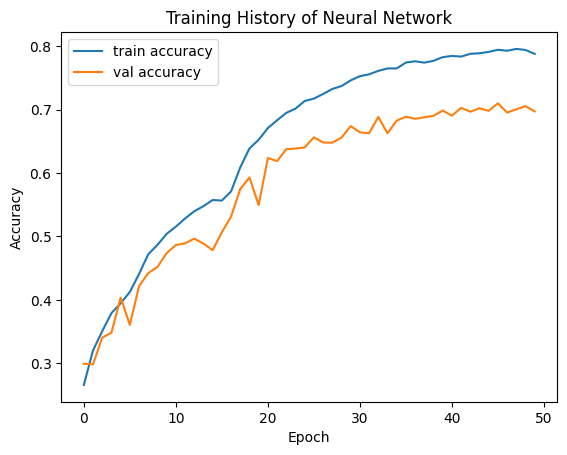

In [7]:
plt.plot(history_nn["accuracy"], label="train accuracy")
plt.plot(history_nn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

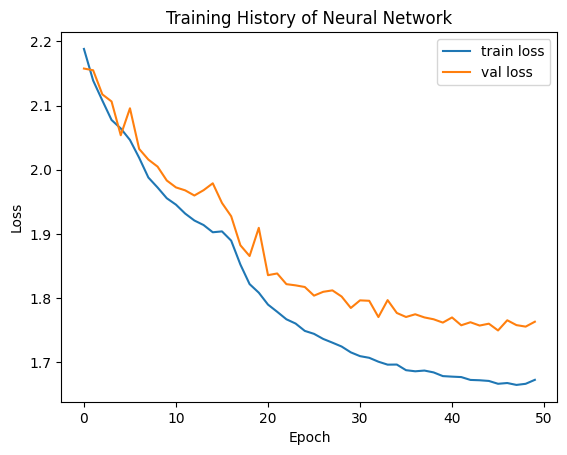

In [8]:
plt.plot(history_nn["loss"], label="train loss")
plt.plot(history_nn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Neural Network")
plt.legend()
plt.show()

In [9]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_nn = correct / total
print(f"Test accuracy: {test_accuracy_nn}")

Test accuracy: 0.6971941638608306


# Convolutional Neural Network

In [10]:
class CNN(nn.Module):
    def __init__(self, inputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2, 2))
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 16, kernel_size=(1, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 1), stride=(2, 2), padding=0)
        self.bn4 = nn.BatchNorm2d(16)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2**int(np.log2(inputs.shape[1])), 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool4(self.relu(self.conv4(x)))
        x = self.bn4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
X, y = get_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

model = CNN(X).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 50
history_cnn = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        inputs = inputs.squeeze(-1)  # Removes the last dimension of size 1
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    history_cnn["loss"].append(train_loss)
    history_cnn["accuracy"].append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history_cnn["val_loss"].append(val_loss)
    history_cnn["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Loss: 1.8569, Accuracy: 0.3306, Val Loss: 1.5453, Val Accuracy: 0.4425
Epoch 2/50, Loss: 1.4496, Accuracy: 0.4907, Val Loss: 1.2691, Val Accuracy: 0.5615
Epoch 3/50, Loss: 1.2308, Accuracy: 0.5749, Val Loss: 1.1180, Val Accuracy: 0.6131
Epoch 4/50, Loss: 1.1129, Accuracy: 0.6165, Val Loss: 1.0099, Val Accuracy: 0.6575
Epoch 5/50, Loss: 1.0144, Accuracy: 0.6502, Val Loss: 1.0225, Val Accuracy: 0.6468
Epoch 6/50, Loss: 0.9575, Accuracy: 0.6731, Val Loss: 0.9226, Val Accuracy: 0.6795
Epoch 7/50, Loss: 0.9064, Accuracy: 0.6831, Val Loss: 0.8793, Val Accuracy: 0.6925
Epoch 8/50, Loss: 0.8567, Accuracy: 0.7040, Val Loss: 0.8626, Val Accuracy: 0.7047
Epoch 9/50, Loss: 0.8228, Accuracy: 0.7151, Val Loss: 0.8295, Val Accuracy: 0.7154
Epoch 10/50, Loss: 0.7833, Accuracy: 0.7300, Val Loss: 0.7720, Val Accuracy: 0.7307
Epoch 11/50, Loss: 0.7606, Accuracy: 0.7418, Val Loss: 0.7245, Val Accuracy: 0.7392
Epoch 12/50, Loss: 0.7185, Accuracy: 0.7504, Val Loss: 0.7269, Val Accuracy: 0.7567
E

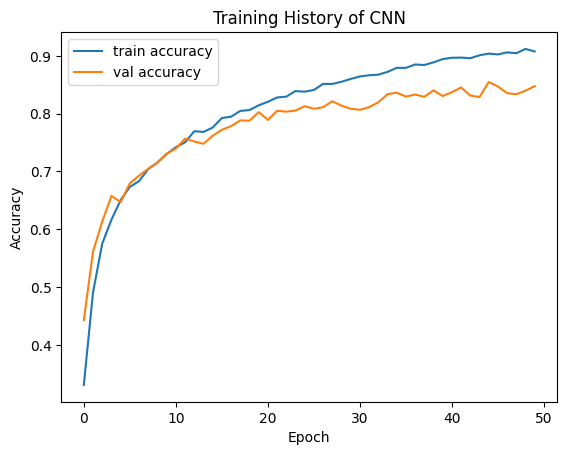

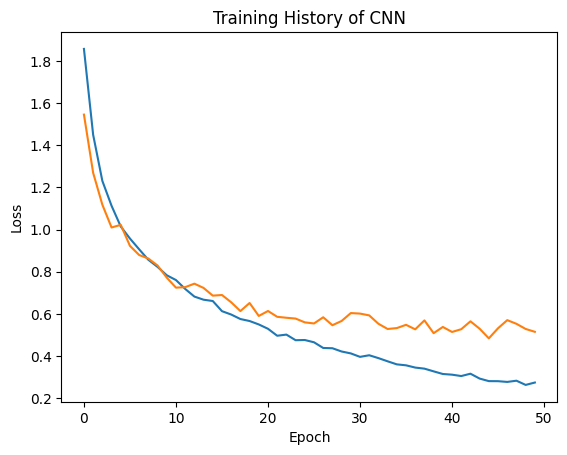

In [12]:
plt.plot(history_cnn["accuracy"], label="train accuracy")
plt.plot(history_cnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend()
plt.show()

plt.plot(history_cnn["loss"], label="train loss")
plt.plot(history_cnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of CNN")
plt.legend
plt.show()

In [13]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader)
test_accuracy_cnn = correct / total
print(f"Test accuracy: {test_accuracy_cnn}")

Test accuracy: 0.8386749259359009


# Recurrent Neural Network

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-12-07 18:24:38.364391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 18:24:38.455226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733613878.490690    4129 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733613878.502306    4129 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 18:24:38.598650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [15]:
%env TF_GPU_ALLOCATOR=cuda_malloc_async

env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [16]:
inputs, targets = get_data()

X_train_full, X_test, y_train_full, y_test = train_test_split(inputs, targets, test_size=0.3)

# One-hot encode labels
y_train_full = to_categorical(y_train_full, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Reshape data for RNN input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [17]:
# Build RNN model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1733613879.597406    4129 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1733613879.597778    4129 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2194 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


In [19]:
# Train model
model_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

# Evaluate model
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(f"Model Test Loss: {model_loss}")
print(f"Model Test Accuracy: {model_accuracy}")

Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.4893 - loss: 1.3995 - val_accuracy: 0.5354 - val_loss: 1.2894
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5427 - loss: 1.2951 - val_accuracy: 0.5570 - val_loss: 1.2054
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5696 - loss: 1.2258 - val_accuracy: 0.5940 - val_loss: 1.1192
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5985 - loss: 1.1352 - val_accuracy: 0.5984 - val_loss: 1.0992
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6221 - loss: 1.0790 - val_accuracy: 0.6364 - val_loss: 1.0294
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6579 - loss: 1.0081 - val_accuracy: 0.6287 - val_loss: 1.0761
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6670 - loss: 0.9842 - val_accuracy: 0.6671 - val_loss: 0.9494
Epoch 8/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7044 - loss: 0.8806 - val_accu

In [20]:
history_rnn = {"accuracy": model_history.history["accuracy"], "val_accuracy": model_history.history["val_accuracy"],
               "loss": model_history.history["loss"], "val_loss": model_history.history["val_loss"]}

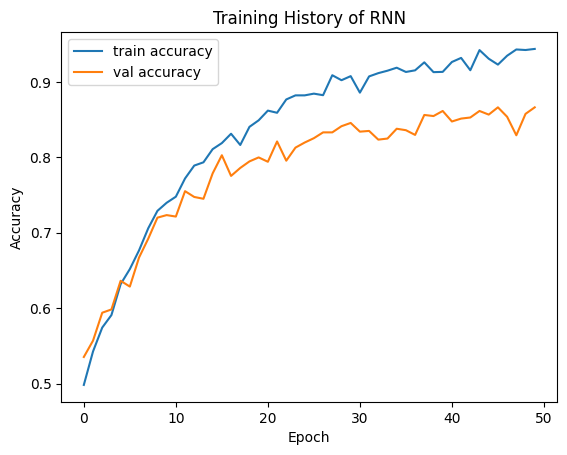

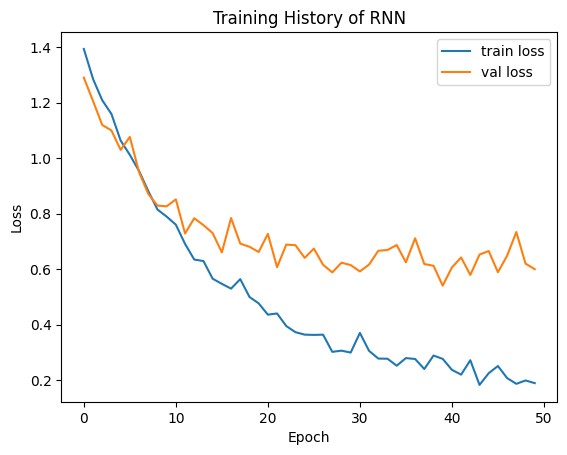

In [21]:
plt.plot(history_rnn["accuracy"], label="train accuracy")
plt.plot(history_rnn["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

plt.plot(history_rnn["loss"], label="train loss")
plt.plot(history_rnn["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of RNN")
plt.legend()
plt.show()

# Improved RNN

In [22]:
# Build improved RNN model
improved_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')  # 10 classes for music genres
])

# Compile improved model
improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train improved model
improved_history = improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate improved model
improved_loss, improved_accuracy = improved_model.evaluate(X_test, y_test)
print(f"Improved Test Loss: {improved_loss}")
print(f"Improved Test Accuracy: {improved_accuracy}")

Epoch 1/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 46s 170ms/step - accuracy: 0.1633 - loss: 3.3101 - val_accuracy: 0.3660 - val_loss: 2.2372 - learning_rate: 0.0010
Epoch 2/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - accuracy: 0.2743 - loss: 2.5172 - val_accuracy: 0.4281 - val_loss: 1.9244 - learning_rate: 0.0010
Epoch 3/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.3131 - loss: 2.2456 - val_accuracy: 0.4353 - val_loss: 1.7726 - learning_rate: 0.0010
Epoch 4/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.3375 - loss: 2.0627 - val_accuracy: 0.4521 - val_loss: 1.6438 - learning_rate: 0.0010
Epoch 5/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.3596 - loss: 1.9255 - val_accuracy: 0.4632 - val_loss: 1.5903 - learning_rate: 0.0010
Epoch 6/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.3783 - loss: 1.8413 - val_accuracy: 0.4781 - val_loss: 1.5145 - learning_rate: 0.0010
Epoch 7/50
260/260 ━━━━━━━━━━━━━━━━━━━━ 46s 176ms/step - accuracy: 0.3

In [24]:
history_rnn_improved = {"accuracy": improved_history.history["accuracy"],
                        "val_accuracy": improved_history.history["val_accuracy"],
                        "loss": improved_history.history["loss"],
                        "val_loss": improved_history.history["val_loss"]}

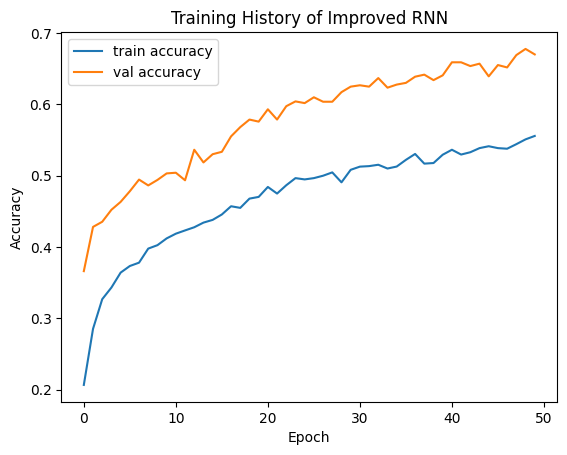

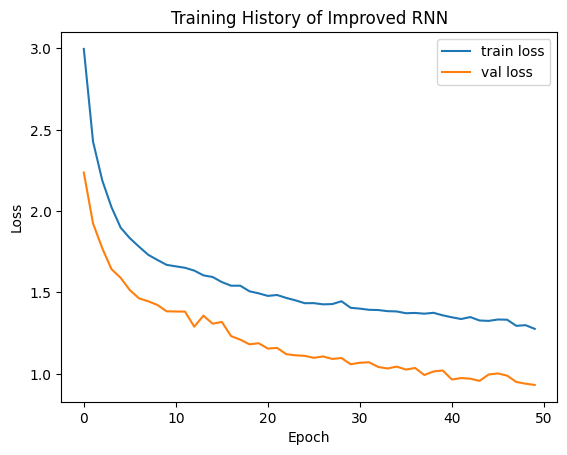

In [25]:
plt.plot(history_rnn_improved["accuracy"], label="train accuracy")
plt.plot(history_rnn_improved["val_accuracy"], label="val accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Improved RNN")
plt.legend()
plt.show()

plt.plot(history_rnn_improved["loss"], label="train loss")
plt.plot(history_rnn_improved["val_loss"], label="val loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History of Improved RNN")
plt.legend()
plt.show()

# Comparison

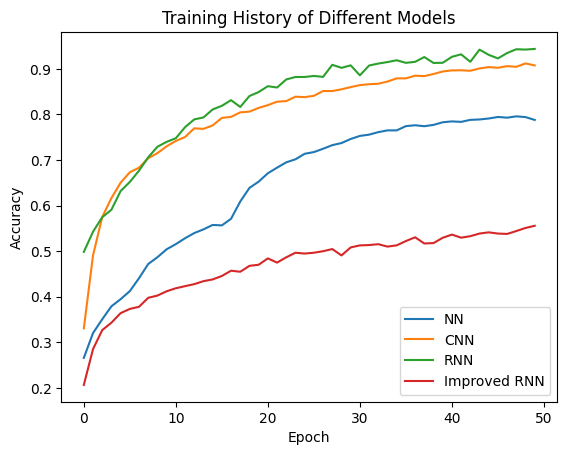

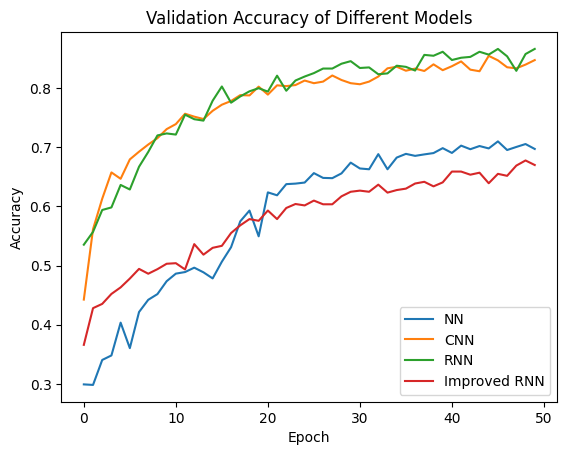

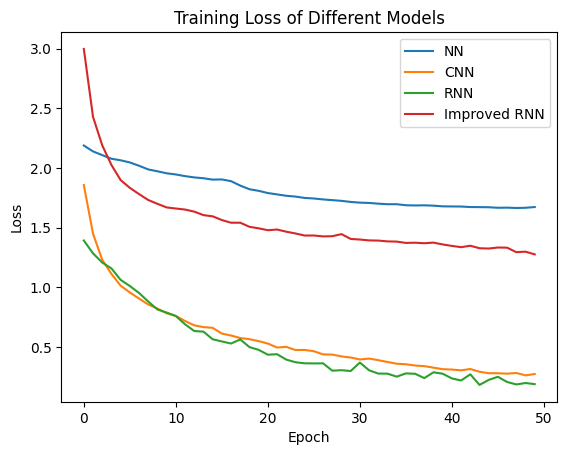

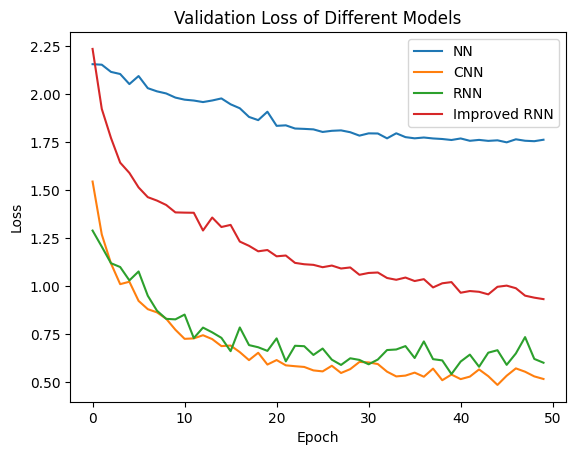

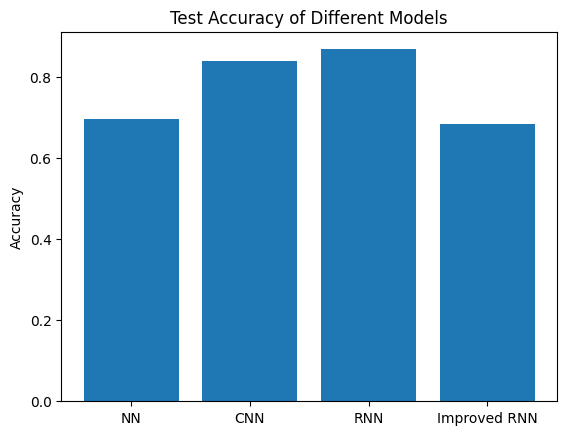

In [26]:
plt.plot(history_nn["accuracy"], label="NN")
plt.plot(history_cnn["accuracy"], label="CNN")
plt.plot(history_rnn["accuracy"], label="RNN")
plt.plot(history_rnn_improved["accuracy"], label="Improved RNN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Training History of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["val_accuracy"], label="NN")
plt.plot(history_cnn["val_accuracy"], label="CNN")
plt.plot(history_rnn["val_accuracy"], label="RNN")
plt.plot(history_rnn_improved["val_accuracy"], label="Improved RNN")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Validation Accuracy of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["loss"], label="NN")
plt.plot(history_cnn["loss"], label="CNN")
plt.plot(history_rnn["loss"], label="RNN")
plt.plot(history_rnn_improved["loss"], label="Improved RNN")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss of Different Models")
plt.legend()
plt.show()

plt.plot(history_nn["val_loss"], label="NN")
plt.plot(history_cnn["val_loss"], label="CNN")
plt.plot(history_rnn["val_loss"], label="RNN")
plt.plot(history_rnn_improved["val_loss"], label="Improved RNN")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Validation Loss of Different Models")
plt.legend()
plt.show()

plt.bar(["NN", "CNN", "RNN", "Improved RNN"], [test_accuracy_nn, test_accuracy_cnn, model_accuracy, improved_accuracy])
plt.ylabel("Accuracy")
plt.title("Test Accuracy of Different Models")
plt.show()

